## Imports

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import os

from sklearn.manifold import TSNE

## Helper functions

In [5]:
def clean_accuracy_data(path, accuracy_column_name):
    df = pd.read_csv(path)
    df.drop(columns=["Wall time"], inplace=True)
    df.rename(columns={"Step": "Batch number", "Value": accuracy_column_name}, inplace=True)
    df[accuracy_column_name] = (df[accuracy_column_name] * 100).round(2)
    df.set_index("Batch number", inplace=True)
    return df

def plot_accuracy_data(df, type="Train", ylim=(0, 100)):
    axis = df.plot(y=["Instantaneous", "Cumulative"], figsize=(15, 5))
    axis.set_title(f"{type} batch accuracy")
    axis.set_xlabel("Batch number")
    axis.set_ylabel("Accuracy")
    axis.set_ylim(*ylim)
    axis.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    axis.xaxis.set_major_formatter(mtick.EngFormatter())
    axis.grid()

def clean_loss_data(path, loss_column_name):
    df = pd.read_csv(path)
    df.drop(columns=["Wall time"], inplace=True)
    df.rename(columns={"Step": "Batch number", "Value": loss_column_name}, inplace=True)
    df.set_index("Batch number", inplace=True)
    return df

def plot_loss_data(df, type="Train", ylim=(0, 1)):
    axis = df.plot(y=["Instantaneous", "Cumulative"], figsize=(15, 5))
    axis.set_title(f"{type} batch cross entropy loss")
    axis.set_xlabel("Batch number")
    axis.set_ylabel("Loss")
    axis.set_ylim(*ylim)
    axis.xaxis.set_major_formatter(mtick.EngFormatter())
    axis.grid()

# Adapted from https://www.kaggle.com/code/jeffd23/visualizing-word-vectors-with-t-sne
def tsne_plot(label_to_embedding, perplexity):
    labels = []
    embedding = []

    for label in label_to_embedding:
        labels.append(label)
        embedding.append(label_to_embedding[label])
    
    tsne_model = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=5000, random_state=23)
    new_embeddings = tsne_model.fit_transform(embeddings)

    x = []
    y = []
    for embedding in new_embeddings:
        x.append(embedding[0])
        y.append(embedding[1])
        
    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


def plot_attention_scores(model, moves, encoder_idx, head_idx):
    input_embedding = result_classifier.get_layer(index=0).input_embedding_layer
    positional_embedding = result_classifier.get_layer(index=0).positional_embedding_layer
    first_encoder_layer = result_classifier.get_layer(index=0).encoder_layers.layers[encoder_idx]
    attention_layer = first_encoder_layer.self_attention_layer.multihead_attention_layer
    
    x = input_embedding(moves)
    x = positional_embedding(x)
    queries = attention_layer.reshape_qkv(attention_layer.W_q(x))
    keys = attention_layer.reshape_qkv(attention_layer.W_k(x))
    
    d_k = tf.cast(512, tf.float32)
    scores = tf.linalg.matmul(queries, keys, transpose_b=True)
    scores /= tf.math.sqrt(d_k)
    weights = tf.nn.softmax(scores)

    head_weights = weights[0, head_idx, :, :].numpy()
    axis = sns.heatmap(head_weights)
    axis.set_title(f"Encoder {encoder_idx + 1}, Attention head {head_idx + 1}")
    plt.show()

## Validation dataset

In [3]:
PIECES = ["p", "n", "b", "r", "q", "k"]
RANK_NAMES = ["1", "2", "3", "4", "5", "6", "7", "8"]
FILE_NAMES = ["a", "b", "c", "d", "e", "f", "g", "h"]
SQUARES = [f + r for r in RANK_NAMES for f in FILE_NAMES]
PROMOTIONS = ["-", "=n", "=b", "=r", "=q"]
POSSIBLE_TOKENS = PIECES + SQUARES + PROMOTIONS

print("Number of tokens:", len(POSSIBLE_TOKENS))

Number of tokens: 75


In [6]:
POSSIBLE_RESULTS = ["0-1", "1-0", "1/2-1/2"]

FEATURE_DESCRIPTION = {
    "moves": tf.io.FixedLenFeature([], tf.string, default_value=''),
    "white_elo": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "black_elo": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "result": tf.io.FixedLenFeature([], tf.string, default_value=''),
}

MAX_GAME_LENGTH = 512

moves_vectorizer = tf.keras.layers.TextVectorization(
    output_mode="int",
    vocabulary=POSSIBLE_TOKENS,
    standardize=None,
    split="whitespace",
    output_sequence_length=MAX_GAME_LENGTH)

results_vectorizer = tf.keras.layers.StringLookup(
    vocabulary=POSSIBLE_RESULTS,
    num_oov_indices=1,
    output_mode="one_hot")

def prepare_example(example_proto):
    example = tf.io.parse_example(example_proto, FEATURE_DESCRIPTION)
    # [:,1:] is used to remove out-of-vocabulary index
    result_embedding = results_vectorizer(example["result"])[:,1:]
    tokenized_moves = moves_vectorizer(example["moves"])
    white_elo = tf.reshape(example["white_elo"], shape=(-1,1))
    black_elo = tf.reshape(example["black_elo"], shape=(-1,1))
    elos = tf.concat(values=[white_elo, black_elo], axis=1)
    return tokenized_moves, elos, result_embedding

validation_dataset_dir = "../data/dataset/validation_data/"
files = sorted([os.path.join(validation_dataset_dir, file) for file in os.listdir(validation_dataset_dir)])
dataset = tf.data.TFRecordDataset(filenames=files,
                                  num_parallel_reads=5,
                                  compression_type="GZIP")
dataset = dataset.batch(1).map(prepare_example)

## Result classifier

In [7]:
result_classifier = tf.keras.models.load_model("../model_artifacts/result_classifier/trained_model/saved_model/chessformer_result_classifier.keras")
result_classifier.summary()

Model: "chessformer_result_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  7395840   
                                                                 
 result_classification (Res  multiple                  37187     
 ultClassification)                                              
                                                                 
Total params: 7433027 (28.35 MB)
Trainable params: 7433027 (28.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


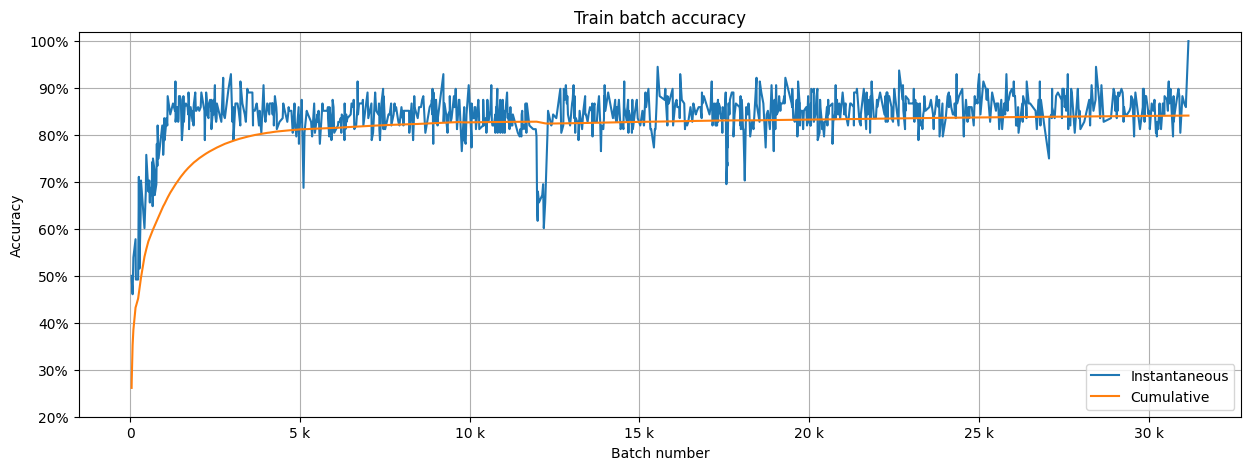

In [6]:
train_inst_acc = clean_accuracy_data(
    "../model_artifacts/result_classifier/training_metrics/train/instantaneous_batch_accuracy_epoch1.csv",
    "Instantaneous"
)
train_cum_acc = clean_accuracy_data(
    "../model_artifacts/result_classifier/training_metrics/train/cumulative_batch_accuracy_epoch1.csv",
    "Cumulative"
)

train_acc = train_inst_acc.join(train_cum_acc)

plot_accuracy_data(train_acc, type="Train", ylim=(20,102))

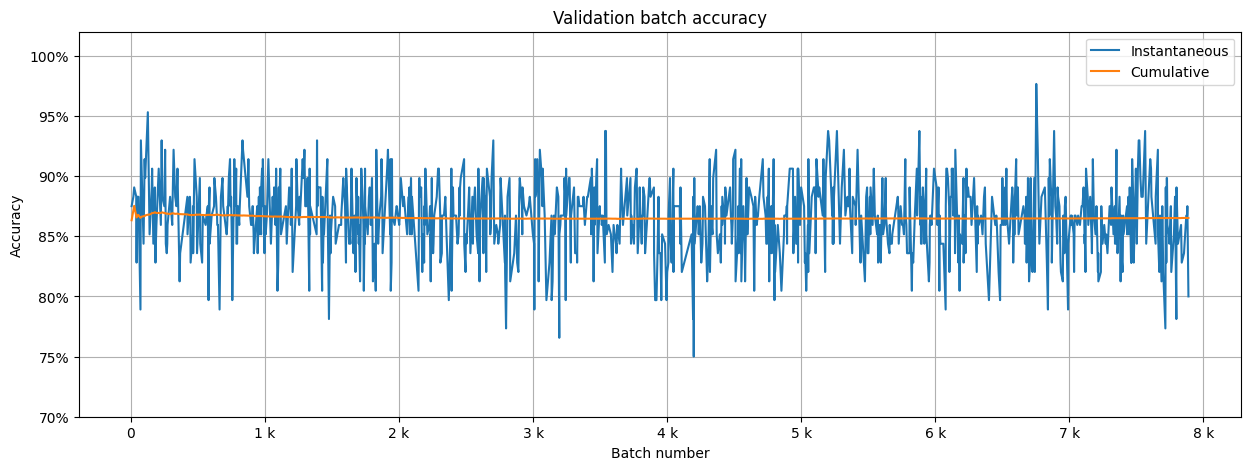

In [100]:
val_inst_acc = clean_accuracy_data(
    "../model_artifacts/result_classifier/training_metrics/validation/instantaneous_batch_accuracy_epoch1.csv",
    "Instantaneous"
)
val_cum_acc = clean_accuracy_data(
    "../model_artifacts/result_classifier/training_metrics/validation/cumulative_batch_accuracy_epoch1.csv",
    "Cumulative"
)

val_acc = val_inst_acc.join(val_cum_acc)

plot_accuracy_data(val_acc, type="Validation", ylim=(70, 102))

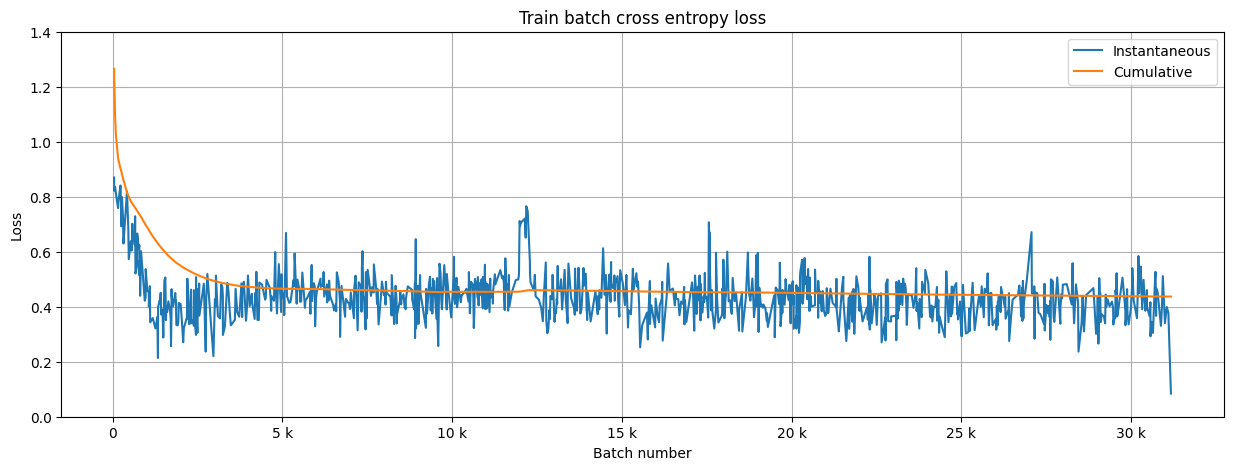

In [112]:
train_inst_loss = clean_loss_data(
    "../model_artifacts/result_classifier/training_metrics/train/instantaneous_batch_loss_epoch1.csv",
    "Instantaneous"
)
train_cum_loss = clean_loss_data(
    "../model_artifacts/result_classifier/training_metrics/train/cumulative_batch_loss_epoch1.csv",
    "Cumulative"
)

train_loss = train_inst_loss.join(train_cum_loss)

plot_loss_data(train_loss, type="Train", ylim=(0, 1.4))

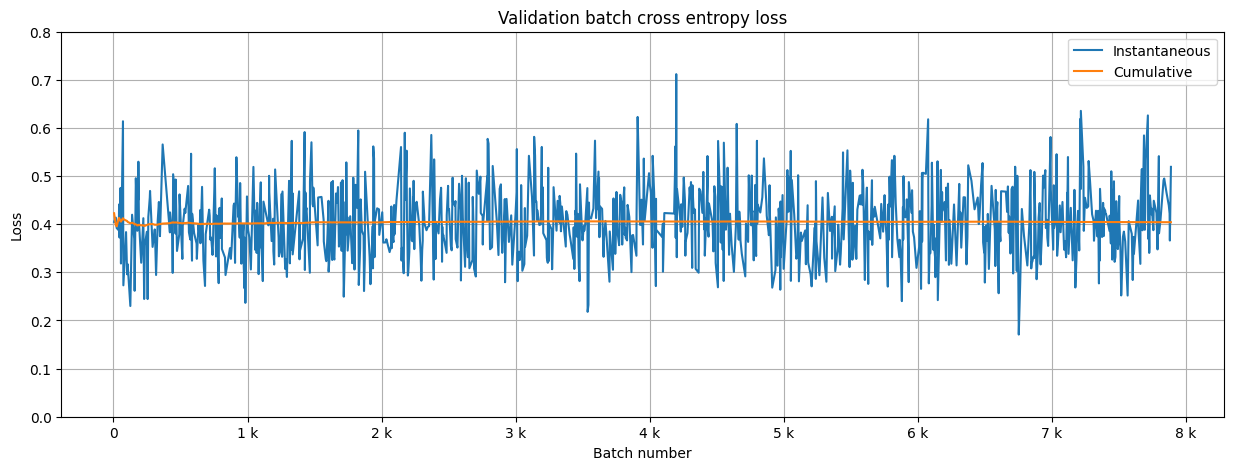

In [115]:
val_inst_loss = clean_loss_data(
    "../model_artifacts/result_classifier/training_metrics/validation/instantaneous_batch_loss_epoch1.csv",
    "Instantaneous"
)
val_cum_loss = clean_loss_data(
    "../model_artifacts/result_classifier/training_metrics/validation/cumulative_batch_loss_epoch1.csv",
    "Cumulative"
)

val_loss = val_inst_loss.join(val_cum_loss)

plot_loss_data(val_loss, type="Validation", ylim=(0, 0.8))

In [9]:
encoder = result_classifier.get_layer(index=0)
embeddings = encoder.input_embedding_layer.get_weights()[0]
print("Original embedding matric shape:", embeddings.shape)
# The first and second embeddings correspond to the empty string and UNK, respectively
# Excluding them here
embeddings = embeddings[2:]
print("Excluding non-chess tokens:", embeddings.shape)

Original embedding matric shape: (77, 512)
Excluding non-chess tokens: (75, 512)


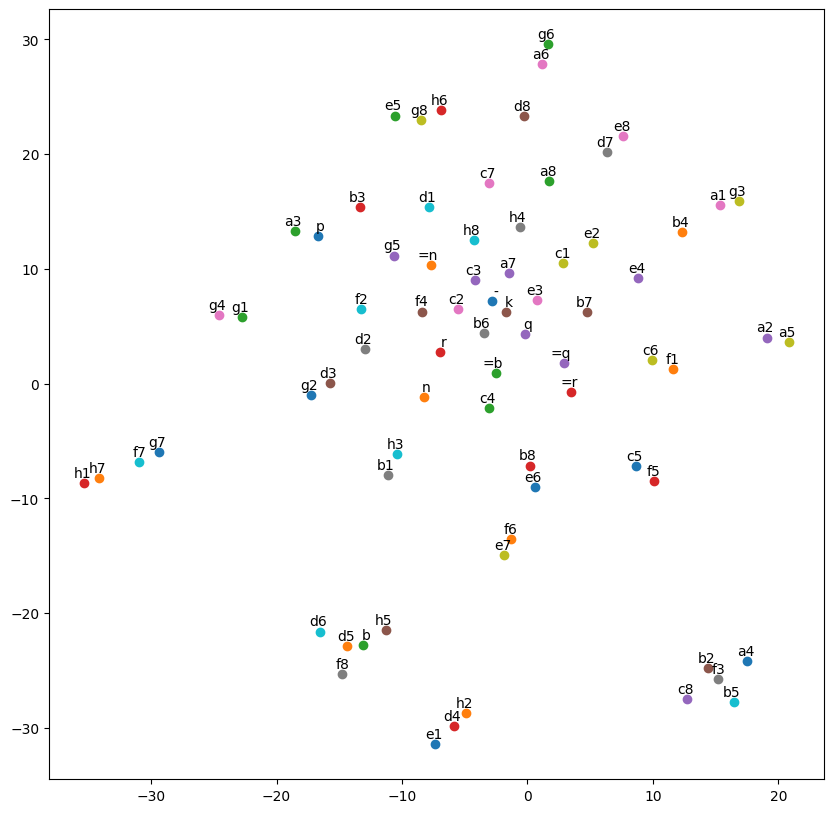

In [22]:
label_to_embedding = {label: embedding for label, embedding in zip(POSSIBLE_TOKENS, embeddings)}

tsne_plot(label_to_embedding, 2)

In [81]:
it = iter(dataset)
moves, elos, result = next(it)

predicted_result = result_classifier.predict(moves)
print("Result:", result)
print("Predicted result:", predicted_result)

1/1 [==============================] - 0s 55ms/step
Result: tf.Tensor([[0. 1. 0.]], shape=(1, 3), dtype=float32)
Predicted result: [[0.01776288 0.9731631  0.00907398]]


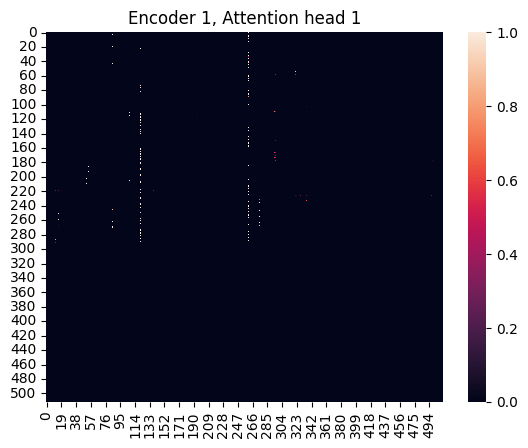

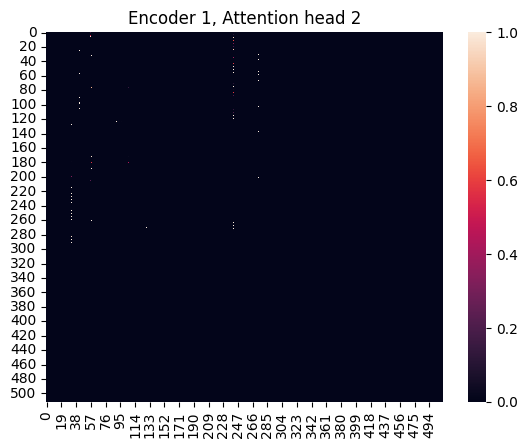

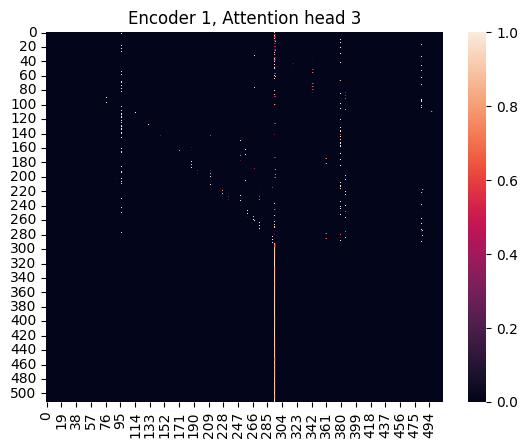

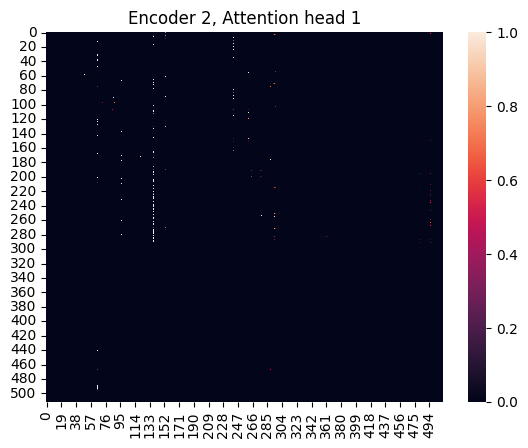

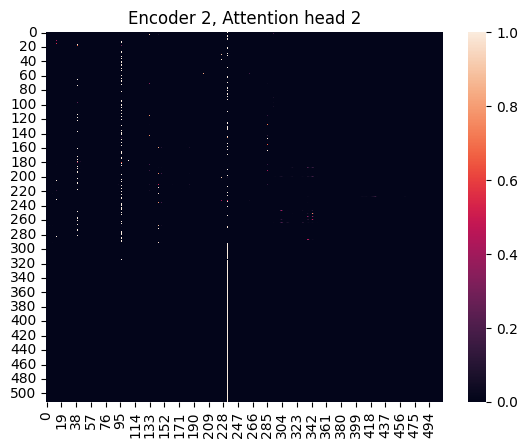

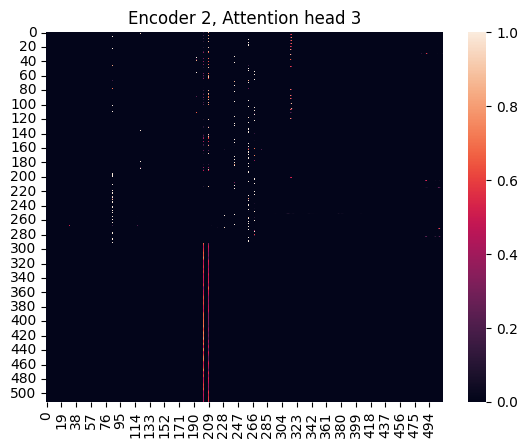

In [236]:
for encoder_idx in range(0, 2):
    for head_idx in range(0, 3):
        plot_attention_scores(result_classifier, moves, encoder_idx, head_idx)

## Elo Regressor

In [8]:
elo_regressor = tf.keras.models.load_model("../model_artifacts/elo_regressor/trained_model/saved_model/chessformer_result_classifier.keras")
elo_regressor.summary()

Model: "chessformer_elo_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  7395840   
                                                                 
 elo_regression (EloRegress  multiple                  37378     
 ion)                                                            
                                                                 
Total params: 7433218 (28.36 MB)
Trainable params: 7433218 (28.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
true_white_elos = list()
true_black_elos = list()
predicted_white_elos = list()
predicted_black_elos = list()

for i, (moves, elos, result) in enumerate(dataset.take(1_000)):
    true_white_elos.append(elos[0][0].numpy())
    true_black_elos.append(elos[0][1].numpy())
    predicted_elos = elo_regressor.predict(moves, verbose=0)
    predicted_white_elos.append(predicted_elos[0][0])
    predicted_black_elos.append(predicted_elos[0][1])
    if i % 100 == 0:
        print(f"Processed {i + 1} examples")

Processed 1 examples
Processed 101 examples
Processed 201 examples
Processed 301 examples
Processed 401 examples
Processed 501 examples
Processed 601 examples
Processed 701 examples
Processed 801 examples
Processed 901 examples


(400.0, 3000.0)

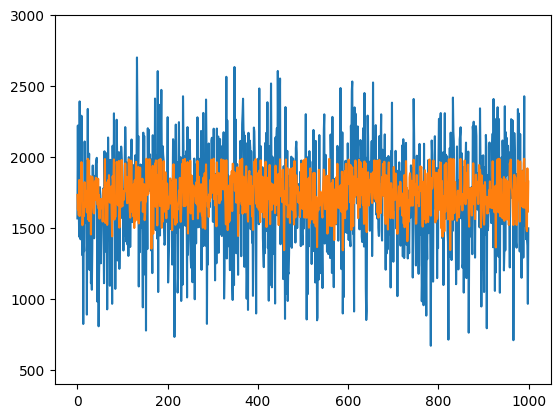

In [40]:
plt.plot(range(1_000), true_white_elos)
plt.ylim(400, 3000)

plt.plot(range(1_000), predicted_white_elos)
plt.ylim(400, 3000)

(400.0, 3000.0)

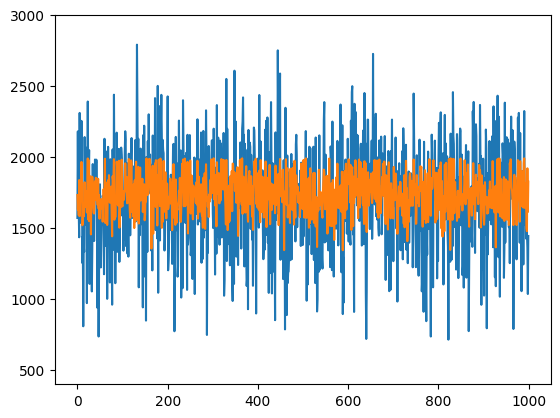

In [41]:
plt.plot(range(1_000), true_black_elos)
plt.ylim(400, 3000)

plt.plot(range(1_000), predicted_black_elos)
plt.ylim(400, 3000)

(400.0, 3000.0)

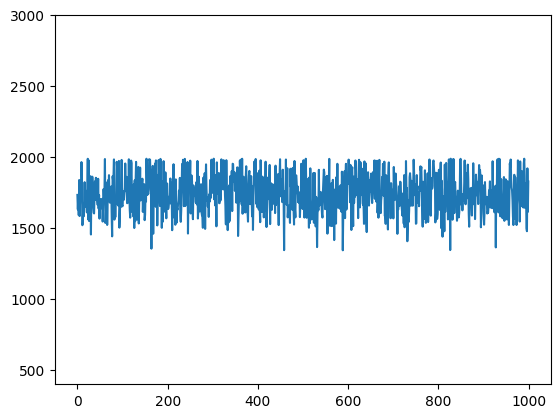

In [43]:
plt.plot(range(1_000), predicted_white_elos)
plt.ylim(400, 3000)

(400.0, 3000.0)

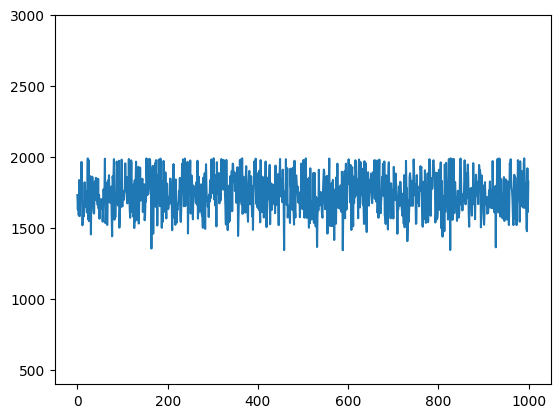

In [44]:
plt.plot(range(1_000), predicted_black_elos)
plt.ylim(400, 3000)

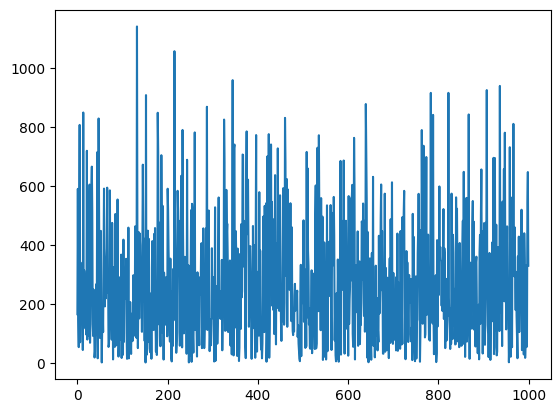

In [46]:
plt.plot(range(1_000), [abs(actual - predicted) for actual, predicted in zip(true_white_elos, predicted_white_elos)])

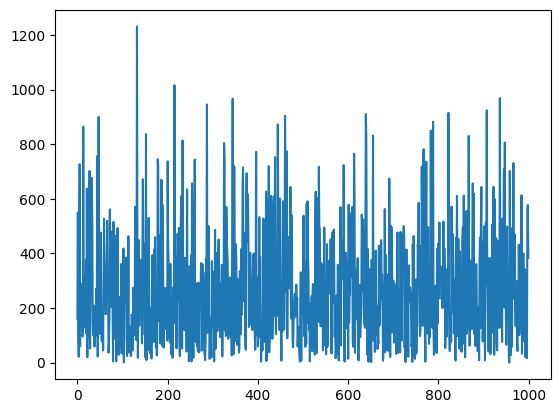

In [47]:
plt.plot(range(1_000), [abs(actual - predicted) for actual, predicted in zip(true_black_elos, predicted_black_elos)])

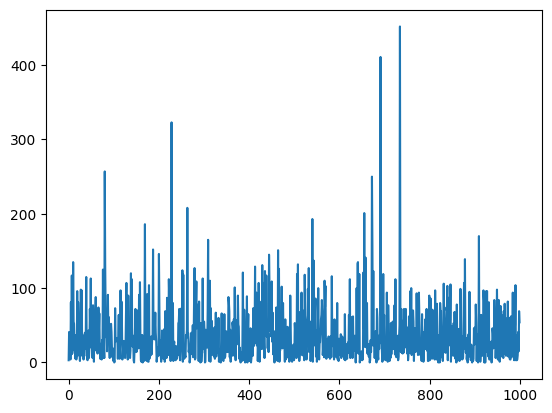

In [48]:
plt.plot(range(1_000), [abs(white - black) for white, black in zip(true_white_elos, true_black_elos)])

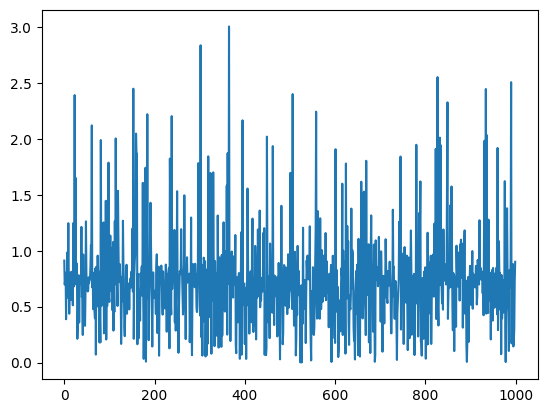

In [49]:
plt.plot(range(1_000), [abs(white - black) for white, black in zip(predicted_white_elos, predicted_black_elos)])